In [1]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

2023-11-20 19:13:17.878584: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 19:13:18.308040: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 19:13:18.316478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 19:13:20.760037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read agricultural data into pandas df

In [2]:
#Read CSV into dataframe
ag_data = pd.read_csv('Agrofood_co2_emission.csv')

#Format column headers
ag_data.columns = ag_data.columns.str.replace(' -', '')
ag_data.columns = ag_data.columns.str.replace('(', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(')', '', regex=True)
ag_data.columns = ag_data.columns.str.replace(' ', '_')
ag_data.columns = map(str.lower, ag_data.columns)


ag_data.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on-farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_°c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [3]:
# ag_data.info()
ag_data.shape

(6965, 31)

### Drop Unecessary Columns:
rural population, male population, female population

In [4]:
ag_data = ag_data.drop(['total_population_female', 'total_population_male', 'rural_population'], axis=1)

In [5]:
# ag_data.info()
ag_data.shape

(6965, 28)

### Combine similar columns:

fires = savanna_fires + forest_fires + fires_in_organic_soils + fires_in_humid_tropical_forests
</br>manure_mgmt = manure_applied_to_soils + manure_left_on_pasture + manure_management
</br>food_systems = food_processing + food_packaging + food_retail + food_transport + food_houshold_consumption + agrifood_systems_waste_disposal
</br>ippu_tot = ippu + pesticides_manufacturing + fertilizers_manufacturing
</br>on_farm_energy_use = on-farm_electricity_use + on-farm_energy_use

In [6]:
ag_data['fires'] = ag_data['savanna_fires']+ag_data['forest_fires']+ag_data['fires_in_organic_soils']+ag_data['fires_in_humid_tropical_forests']
ag_data['manure_mgmt'] = ag_data['manure_applied_to_soils']+ag_data['manure_left_on_pasture']+ag_data['manure_management']
ag_data['food_systems'] = ag_data['food_processing']+ag_data['food_packaging']+ag_data['food_retail']+ag_data['food_transport']+ag_data['food_household_consumption']+ag_data['agrifood_systems_waste_disposal']
ag_data['ippu_tot'] = ag_data['ippu']+ag_data['pesticides_manufacturing']+ag_data['fertilizers_manufacturing']
ag_data['on_farm_energy_use'] = ag_data['on-farm_electricity_use'] + ag_data['on-farm_energy_use']

In [7]:
#Drop individual columns
ag_data = ag_data.drop(['savanna_fires', 'forest_fires', 'fires_in_organic_soils', 'fires_in_humid_tropical_forests',
                       'manure_applied_to_soils', 'manure_left_on_pasture', 'manure_management', 'food_processing',
                       'food_packaging', 'food_retail', 'food_transport', 'food_household_consumption',
                       'agrifood_systems_waste_disposal', 'ippu', 'pesticides_manufacturing', 'fertilizers_manufacturing',
                       'on-farm_electricity_use', 'on-farm_energy_use'], axis=1)

In [8]:
# ag_data.info()
ag_data.shape

(6965, 15)

### Read Multivariate ENSO Index (MEI) data into pandas df

In [9]:
enso_data = pd.read_csv('meiv2.csv')
enso_data.columns = map(str.lower, enso_data.columns)

#Drop years before 1990 and after 2020
enso_data = enso_data[enso_data['year'] <= 2020]
enso_data = enso_data[enso_data['year'] > 1989]

enso_data = enso_data.set_index('year')

#Calculate yearly average index
enso_data['mei'] = enso_data.mean(axis=1)

#Reset index
enso_data = enso_data.reset_index(names=['year'])

#Drop months columns
enso_data = enso_data.drop(["dj",'jf','fm','ma','am','mj','jj','ja','as','so','on','nd'], axis='columns')

### Join DFs

In [10]:
ag_data = ag_data.merge(enso_data, left_on='year', right_on='year')

In [11]:
ag_data.head()

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
0,Afghanistan,1990,205.6077,686.000000,0.0000,-2388.8030,0.0000,2593947.0,2198.963539,0.536167,14.7794,2169.8513,1263.479256,233.782283,NaN,0.2
1,Albania,1990,59.2391,23.520000,110.5705,72.8581,0.0000,1195379.0,3475.291240,0.735750,12.5814,1054.6462,650.148524,1125.636617,366.090800,0.2
2,Algeria,1990,164.2776,4.312000,0.0000,-111.1403,684.9333,13496502.0,22326.596965,1.005583,144.6946,2758.8447,13250.763265,5288.278000,141.633800,0.2
3,American Samoa,1990,NaN,926.342278,0.0000,-58.8991,7.9612,38076.0,5299.122499,0.566500,0.0000,NaN,199.688951,NaN,58.504263,0.2
4,Andorra,1990,NaN,926.342278,0.0000,0.0000,0.0000,51627.0,5576.553292,1.278500,0.0000,NaN,570.011357,1711.187476,74.704263,0.2


In [12]:
# ag_data.info()
ag_data.shape

(6965, 16)

### Read Continents Data into Pandas DF

In [13]:
region_data = pd.read_csv('continents.csv')
# https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
# linked from kaggle: https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region

In [14]:
# drop columns not needed
region_data = region_data.drop(['alpha-2', 'alpha-3', 'country-code', 'iso_3166-2','intermediate-region', 
                                'region-code', 'sub-region-code','intermediate-region-code'], axis=1)

### Merge Regions into Emissions DF

In [15]:
ag_data = ag_data.merge(region_data, left_on='area', right_on='name', how='left').drop(['name'], axis=1)

In [16]:
# manually update region & sub-region information:

def update_regions():

    asia_region = ['China, Hong Kong SAR',
                    'China, Macao SAR',
                    'China, Taiwan Province of',
                    'China, mainland',
                    "Democratic People's Republic of Korea",
                    'Republic of Korea']
    
    for area in asia_region:
        ag_data.loc[ag_data['area']==area,'region']='Asia'
        ag_data.loc[ag_data['area']==area,'sub-region']='Eastern Asia'

    
    # 'British Virgin Islands' # Americas, Latin America and the Caribbean 
    # 'United States Virgin Islands' # Americas, Latin America and the Caribbean
    americas_region = ['British Virgin Islands', 'United States Virgin Islands']    
    
    for area in americas_region:
        ag_data.loc[ag_data['area']==area,'region']='Americas'
        ag_data.loc[ag_data['area']==area,'sub-region']='Latin America and the Caribbean'
    
    #'Palestine' # Asia, Western Asia
    ag_data.loc[ag_data['area']=='Palestine','region']='Asia'
    ag_data.loc[ag_data['area']=='Palestine','sub-region']='Western Asia'

    # 'Wallis and Futuna Islands' # Oceania, Polynesia
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','region']='Oceania'
    ag_data.loc[ag_data['area']=='Wallis and Futuna Islands','sub-region']='Polynesia'

    # 'Republic of Moldova' # Europe, Eastern Europe
    # 'Serbia and Montenegro' # Europe, Southern Europe
    # 'Channel Islands' # Europe, Northern Europe
    # 'Netherlands (Kingdom of the)' # Europe, Western Europe
    # 'Belgium-Luxembourg' # Europe, Western Europe
    europe_region = ['Republic of Moldova',
                     'Serbia and Montenegro',
                     'Channel Islands',
                     'Netherlands (Kingdom of the)',
                     'Belgium-Luxembourg']
    for area in europe_region:
        ag_data.loc[ag_data['area']==area,'region']='Europe'
        ag_data.loc[ag_data['area']==area,'sub-region']='Western Europe'

    ag_data.loc[ag_data['area']=='Republic of Moldova','sub-region']='Eastern Europe'
    ag_data.loc[ag_data['area']=='Serbia and Montenegro','sub-region']='Southern Europe'
    ag_data.loc[ag_data['area']=='Channel Islands','sub-region']='Northern Europe'
    

    # 'Ethiopia PDR' # Afria, Sub-Saharan Africa
    # 'United Republic of Tanzania' # Afria, Sub-Saharan Africa
    # 'Democratic Republic of the Congo' # Africa, Sub-Saharan Africa
    africa_region = ['Ethiopia PDR', 'United Republic of Tanzania', 'Democratic Republic of the Congo']

    for area in africa_region:
        ag_data.loc[ag_data['area']==area,'region']='Africa'
        ag_data.loc[ag_data['area']==area,'sub-region']='Sub-Saharan Africa'


update_regions()

In [17]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

area
Czechoslovakia                      3
Netherlands Antilles (former)      21
Pacific Islands Trust Territory     1
Sudan (former)                     22
USSR                                2
Yugoslav SFR                        2
Name: year, dtype: int64

### Evaluate Countries with fewer than 31 years:

In [18]:
ag_data_area = ag_data.groupby('area').sum()
ag_data_area.loc[ag_data_area['year'] != 62155]

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Armenia,58174,867.9864,7193.783413,0.000000e+00,-7.207147e+02,2917.1471,5.635726e+07,9.744722e+04,30.398333,147.4283,12704.6754,3.341263e+04,3.442255e+04,6501.743700,-2.933333
Azerbaijan,58174,4224.8868,540.850300,0.000000e+00,-6.026048e+04,4081.8835,1.347994e+08,2.730205e+05,30.718750,869.7217,57311.7177,1.505620e+05,5.691915e+04,58770.713500,-2.933333
Belarus,58174,12870.7709,26863.926076,1.237739e+06,-1.428863e+06,44432.5316,2.051809e+08,7.723587e+05,43.376000,1139.1979,118212.6124,2.316582e+05,4.285815e+05,99724.217100,-2.933333
Belgium,42210,3792.0467,15238.494610,4.233712e+03,-6.181097e+04,13283.4030,2.241269e+08,7.635175e+05,31.193667,1.7183,79432.2159,2.515535e+05,4.073839e+05,50409.423300,-4.991667
Belgium-Luxembourg,19945,1530.0201,7733.039548,2.170152e+03,-5.741164e+04,10069.1510,1.015337e+08,2.627709e+05,8.839917,1.6377,45740.5605,0.000000e+00,1.623048e+05,0.000000,2.933333
Bosnia and Herzegovina,58174,1935.6795,7215.045405,3.432881e+03,3.991576e+03,0.0000,4.783055e+07,1.499274e+05,34.322833,663.6878,22613.4146,6.318621e+04,4.474690e+04,2141.983400,-2.933333
Croatia,58174,4609.2055,16056.151542,2.582154e+02,-5.376840e+04,8217.6994,6.917302e+07,2.354761e+05,36.427000,358.3903,26695.2161,7.960718e+04,1.300727e+05,23369.795000,-2.933333
Czechia,56182,12395.6109,24001.145653,7.543190e+03,-2.141410e+05,18459.6918,2.156180e+08,5.359970e+05,38.685250,16.0832,47520.7339,3.448612e+05,2.315051e+05,63835.296700,-4.125000
Czechoslovakia,5973,2158.5798,2779.026835,1.048374e+03,-5.914724e+04,2036.8200,3.234779e+07,3.579869e+04,2.250750,2.8005,14987.4518,2.195435e+04,3.603314e+04,13301.816100,2.066667


### Drop Belgium-Luxembourg

Not sure why Belgium & Luxembourg are reported together between 1990 and 2000, but not sure how to accurately split info for these years into each country. Propose dropping these data points. 

In [19]:
# ag_data[ag_data['area'] == 'Belgium']
# ag_data[ag_data['area'] == 'Luxembourg']
# ag_data[ag_data['area'] == 'Belgium-Luxembourg']

ag_data = ag_data[ag_data['area'] != 'Belgium-Luxembourg']

### Drop Czechoslovakia

Czeochoslovakia split into Czechia (Czech Republic) & Slovakia in 1993. Czechoslavakia data between 1990-1992 represents the entire region. Only lose 3 years of data. 

In [20]:
# ag_data[ag_data['area'] == 'Czechia']
# ag_data[ag_data['area'] == 'Czechoslovakia']
# ag_data[ag_data['area'] == 'Slovakia']

ag_data = ag_data[ag_data['area'] != 'Czechoslovakia']

### Drop USSR

Soviet Union fell in 1991. Drop 1990-1991. 

In [21]:
# ag_data[ag_data['area'] == 'USSR']
    
ag_data = ag_data[ag_data['area'] != 'USSR']

### Drop Yugoslavia SFR

SFRY ended in 1991

In [22]:
# ag_data[ag_data['area'] == 'Yugoslav SFR']

ag_data = ag_data[ag_data['area'] != 'Yugoslav SFR']

### Drop Pacific Islands Trust Territory

Split into Micronesia, Marshall Islands, and Palau. Only drop 1990.

In [23]:
# ag_data[ag_data['area'] == 'Pacific Islands Trust Territory']

ag_data = ag_data[ag_data['area'] != 'Pacific Islands Trust Territory']

### Rename Ethiopia PDR to Ethiopia

In [24]:
#ag_data[ag_data['area'] == 'Ethiopia PDR']
#ag_data[ag_data['area'] == 'Ethiopia']

ag_data.loc[ag_data["area"] == "Ethiopia PDR", 'area'] = "Ethiopia"

### Drop Serbia, Montenegro, Serbia & Montenegro

These countries were in a union until 2006. Very difficult to split or interpret this data. Not enough data left if we remove Serbia & Montenegro data points. Propose removing all 3 from datasest. 

In [25]:
ag_data = ag_data[ag_data['area'] != 'Serbia']
ag_data = ag_data[ag_data['area'] != 'Montenegro']
ag_data = ag_data[ag_data['area'] != 'Serbia and Montenegro']

### Drop Sudan(former), Sudan, and South Sudan

Split into two countries in 2011. Very difficult to split or interpret data prior to split. Propose removing all 3 from dataset. 

In [26]:
ag_data = ag_data[ag_data['area'] != 'Sudan (former)']
ag_data = ag_data[ag_data['area'] != 'Sudan']
ag_data = ag_data[ag_data['area'] != 'South Sudan']

### Drop Netherlands Antiles

Was a country made up of dutch colonized islands. Dissolved in 2010. Not sufficient data to keep. Propose removing. 

In [27]:
ag_data = ag_data[ag_data['area'] != 'Netherlands Antilles (former)']

### Confirm no areas are missing region data

In [28]:
# areas not in region data set
ag_data[ag_data.region.isna()].groupby('area')['year'].count()

Series([], Name: year, dtype: int64)

In [29]:
ag_data.shape

(6842, 18)

In [30]:
ag_data['area'].nunique()

223

### Find missing values by year

In [31]:

#define an array with the unique year values
years_count_missing = dict.fromkeys(ag_data['year'].unique(), 0)
for ind, row in ag_data.iterrows():
    years_count_missing[row['year']] += row.isnull().sum()

# sort the years by missing values
years_missing_sorted = dict(sorted(years_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each year
print("missing values by year:")
for key, val in years_missing_sorted.items():
    print(key, ":", val)

missing values by year:
1990 : 172
2002 : 177
2003 : 177
2004 : 177
2006 : 177
2007 : 177
2008 : 177
2009 : 177
2010 : 177
2011 : 177
2012 : 177
2013 : 177
2014 : 177
2005 : 178
2015 : 178
2016 : 178
2017 : 178
2018 : 178
2019 : 178
1999 : 179
2000 : 179
2001 : 179
1995 : 180
1996 : 180
1997 : 180
1998 : 180
1994 : 181
2020 : 181
1992 : 185
1993 : 185
1991 : 191


### Find missing values by country

In [32]:
# define an array with the unique country values
areas_count_missing = dict.fromkeys(ag_data['area'].unique(), 0)

# iterate through all rows and count the amount of NaN values for each country
for ind, row in ag_data.iterrows():
    areas_count_missing[row['area']] += row.isnull().sum()

# sort the countries by missing values
areas_missing_sorted = dict(sorted(areas_count_missing.items(), key=lambda item: item[1]))

# print the missing values for each country
print("missing values by area:")
for key, val in areas_missing_sorted.items():
    print(key, ":", val)

missing values by area:
Albania : 0
Algeria : 0
Angola : 0
Argentina : 0
Australia : 0
Austria : 0
Bahamas : 0
Bangladesh : 0
Barbados : 0
Belize : 0
Benin : 0
Bhutan : 0
Bolivia (Plurinational State of) : 0
Botswana : 0
Brazil : 0
Brunei Darussalam : 0
Bulgaria : 0
Burundi : 0
Cabo Verde : 0
Cambodia : 0
Canada : 0
Central African Republic : 0
Chad : 0
Chile : 0
China : 0
China, mainland : 0
Colombia : 0
Comoros : 0
Congo : 0
Costa Rica : 0
Cuba : 0
Cyprus : 0
Democratic People's Republic of Korea : 0
Denmark : 0
Djibouti : 0
Dominica : 0
Dominican Republic : 0
Ecuador : 0
Egypt : 0
El Salvador : 0
Eswatini : 0
Finland : 0
France : 0
Gabon : 0
Ghana : 0
Greece : 0
Grenada : 0
Guatemala : 0
Guinea : 0
Guinea-Bissau : 0
Guyana : 0
Haiti : 0
Honduras : 0
Hungary : 0
Iceland : 0
India : 0
Indonesia : 0
Iran (Islamic Republic of) : 0
Ireland : 0
Israel : 0
Italy : 0
Jamaica : 0
Japan : 0
Jordan : 0
Kenya : 0
Lao People's Democratic Republic : 0
Lebanon : 0
Malawi : 0
Malaysia : 0
Mali : 0


### Drop Countries with 2 or more missing columns

In [33]:
areas_null_count = ag_data.groupby(['area']).apply(lambda x: x.isnull().sum())
areas_null_count['total_null']=areas_null_count.sum(axis=1)
included_areas = areas_null_count.area[areas_null_count['total_null']<63].index
# filter ag_data for included areas only
ag_data = ag_data[ag_data['area'].isin(included_areas)]

In [34]:
# ag_data[ag_data['area']=='Northern Mariana Islands']

In [35]:
# areas_missing_10 = dict((k, v) for k, v in areas_missing_sorted.items() if v >= 56)

In [36]:
# areas_missing_10_list = list(areas_missing_10.keys())

In [37]:
# areas_missing_10_list

In [38]:
# len(areas_missing_10_list)

In [39]:
# for area in areas_missing_10_list:
    # ag_data = ag_data[ag_data.area != area]

In [40]:
# ag_data.shape

In [41]:
# # define an array with the unique country values
# areas_count_missing = dict.fromkeys(ag_data['area'].unique(), 0)

# # iterate through all rows and count the amount of NaN values for each country
# for ind, row in ag_data.iterrows():
#     areas_count_missing[row['area']] += row.isnull().sum()

# # sort the countries by missing values
# areas_missing_sorted = dict(sorted(areas_count_missing.items(), key=lambda item: item[1]))

# # print the missing values for each country
# print("missing values by area:")
# for key, val in areas_missing_sorted.items():
#     print(key, ":", val)

In [42]:

# #define an array with the unique year values
# years_count_missing = dict.fromkeys(ag_data['year'].unique(), 0)
# for ind, row in ag_data.iterrows():
#     years_count_missing[row['year']] += row.isnull().sum()

# # sort the years by missing values
# years_missing_sorted = dict(sorted(years_count_missing.items(), key=lambda item: item[1]))

# # print the missing values for each year
# print("missing values by year:")
# for key, val in years_missing_sorted.items():
#     print(key, ":", val)

### Impute Null Values

Compute average emissions for all columns, group by year and sub-region
</br>Replace null values with average value for that year and sub-region

In [43]:
ag_data.isnull().sum()

area                           0
year                           0
crop_residues                435
rice_cultivation               0
drained_organic_soils_co2      0
forestland                   122
net_forest_conversion        122
urban_population               0
total_emission                 0
average_temperature_°c         0
fires                          0
manure_mgmt                  158
food_systems                 132
ippu_tot                     124
on_farm_energy_use           606
mei                            0
region                         0
sub-region                     0
dtype: int64

In [44]:
ag_data.shape

(5821, 18)

In [45]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Andorra,62155,0.0,28716.610633,0.0000,0.0000,0.0000,2038525.0,163914.151678,39.800000,0.0000,0.0000,8542.204360,53007.193557,2340.875946,-2.058333
Aruba,62155,0.0,60320.883163,0.0000,-1.7989,0.0000,1311424.0,205325.247943,24.766342,0.0000,0.0000,22373.504275,50012.139891,887.887100,-2.058333
Bahrain,4025,0.0,1515.513286,0.0000,-5.1600,0.0000,2305816.0,14630.473086,3.334500,0.0000,66.1694,5475.665800,7499.039600,0.000000,-0.683333
Cook Islands,62155,0.0,28840.927293,0.0000,-298.8975,0.0000,389220.0,80561.005195,7.669833,0.0000,455.1356,0.000000,33187.644291,141.007200,-2.058333
Equatorial Guinea,62155,0.0,25615.721335,1.3162,-63030.9163,181798.1238,15478753.0,231010.733962,22.450683,13.4529,281.9080,14110.303996,70548.273031,1672.551000,-2.058333
Marshall Islands,60165,0.0,60831.997342,0.0000,0.0000,0.0000,1115375.0,199762.275750,7.979167,0.0000,0.0000,15452.424260,50328.593916,217.638800,-2.258333
Nauru,62155,0.0,29379.607125,0.0000,0.0000,0.0000,318582.0,65103.097417,16.492636,0.0000,41.8846,8451.234184,27039.328008,191.043500,-2.058333
Niue,62155,0.0,62174.634696,0.0000,-23.2440,39.3963,20465.0,100404.048472,20.647394,0.0000,34.3373,10631.128696,27018.770734,529.024746,-2.058333
Saint Lucia,62155,0.0,37066.621272,0.0000,-4429.9344,237.7080,1169200.0,73289.828260,20.849333,0.0000,369.1003,13724.700527,25645.574687,676.057874,-2.058333


In [46]:
#Replace null values with calculated sub-region averages by year

def impute_null(df):
    cols = df.columns.tolist()
    for col in cols:
        null_indeces = df[df[col].isnull()].index.tolist()
        for index in null_indeces:
            year = df['year'][index]
            sub_region = df['sub-region'][index]
            new_value = df[(df['year']==year) & (df['sub-region']==sub_region)][col].aggregate('mean')
            df[col][index] = new_value
    return df

In [47]:
ag_data = impute_null(ag_data)

### Confirm if any additional nulls after imputing

Nauru still has null value for crop_residues in 1990 because it is the only remaining country in the Micronesia sub-region. 
Chnage this one value to zero. 

In [48]:
ag_data.isnull().sum()

area                         0
year                         0
crop_residues                1
rice_cultivation             0
drained_organic_soils_co2    0
forestland                   0
net_forest_conversion        0
urban_population             0
total_emission               0
average_temperature_°c       0
fires                        0
manure_mgmt                  0
food_systems                 0
ippu_tot                     0
on_farm_energy_use           0
mei                          0
region                       0
sub-region                   0
dtype: int64

In [49]:
ag_data.shape

(5821, 18)

In [50]:
ag_data[ag_data['crop_residues'].isnull()].groupby('area').sum()

,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei
area,,,,,,,,,,,,,,,
Nauru,1990,0.0,921.664109,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,0.2


In [51]:
#Nauru is the only sub-region of Micronesia
ag_data[(ag_data['sub-region']== 'Micronesia') & (ag_data['year']==1990)]

,area,year,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,urban_population,total_emission,average_temperature_°c,fires,manure_mgmt,food_systems,ippu_tot,on_farm_energy_use,mei,region,sub-region
126,Nauru,1990,NaN,921.664109,0.0,0.0,0.0,9155.0,2282.058615,-0.18075,0.0,1.179,474.942226,872.41178,11.8615,0.2,Oceania,Micronesia


In [52]:
ag_data = ag_data.fillna(0)

In [53]:
ag_data.isnull().sum()

area                         0
year                         0
crop_residues                0
rice_cultivation             0
drained_organic_soils_co2    0
forestland                   0
net_forest_conversion        0
urban_population             0
total_emission               0
average_temperature_°c       0
fires                        0
manure_mgmt                  0
food_systems                 0
ippu_tot                     0
on_farm_energy_use           0
mei                          0
region                       0
sub-region                   0
dtype: int64

### Visualize Distribution of Vars

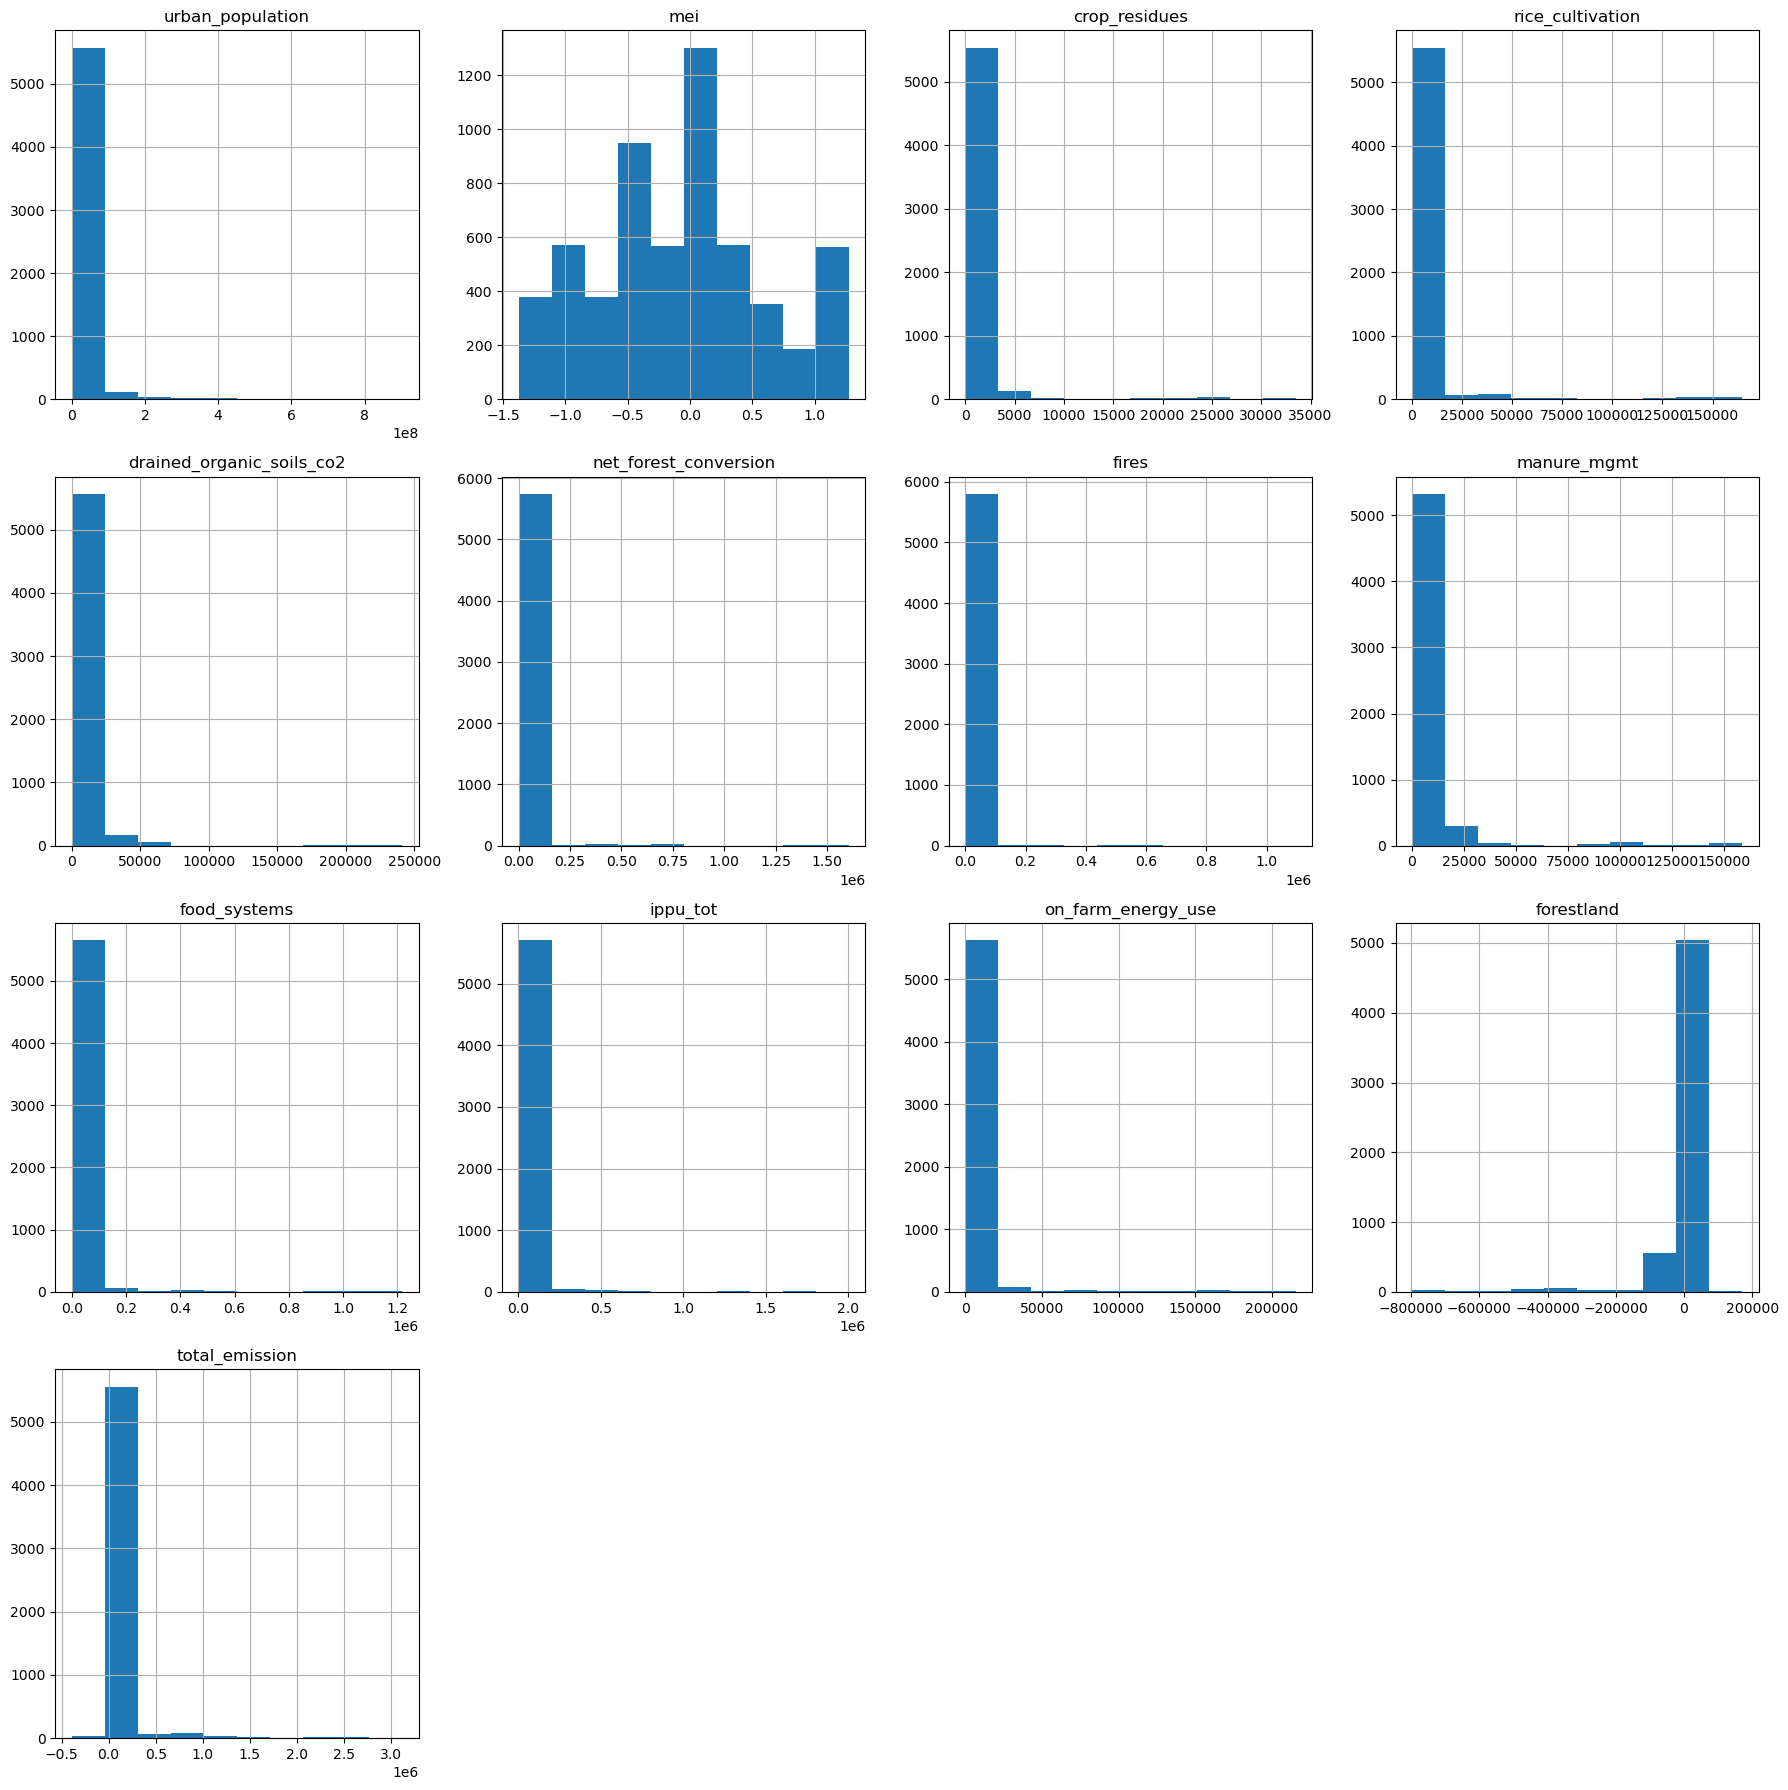

In [54]:
vars = [
 'urban_population',
 'mei',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use',
 'forestland',
 'total_emission']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, vars, 4,4)

### Add Log Transforms of non-normally distributed variables

In [55]:
log_vars = [
 'urban_population',
 'crop_residues',
 'rice_cultivation',
 'drained_organic_soils_co2',
 'net_forest_conversion',
 'fires',
 'manure_mgmt',
 'food_systems',
 'ippu_tot',
 'on_farm_energy_use']

for col in log_vars:
    ag_data['log_'+col] = np.log(ag_data[col]+1)

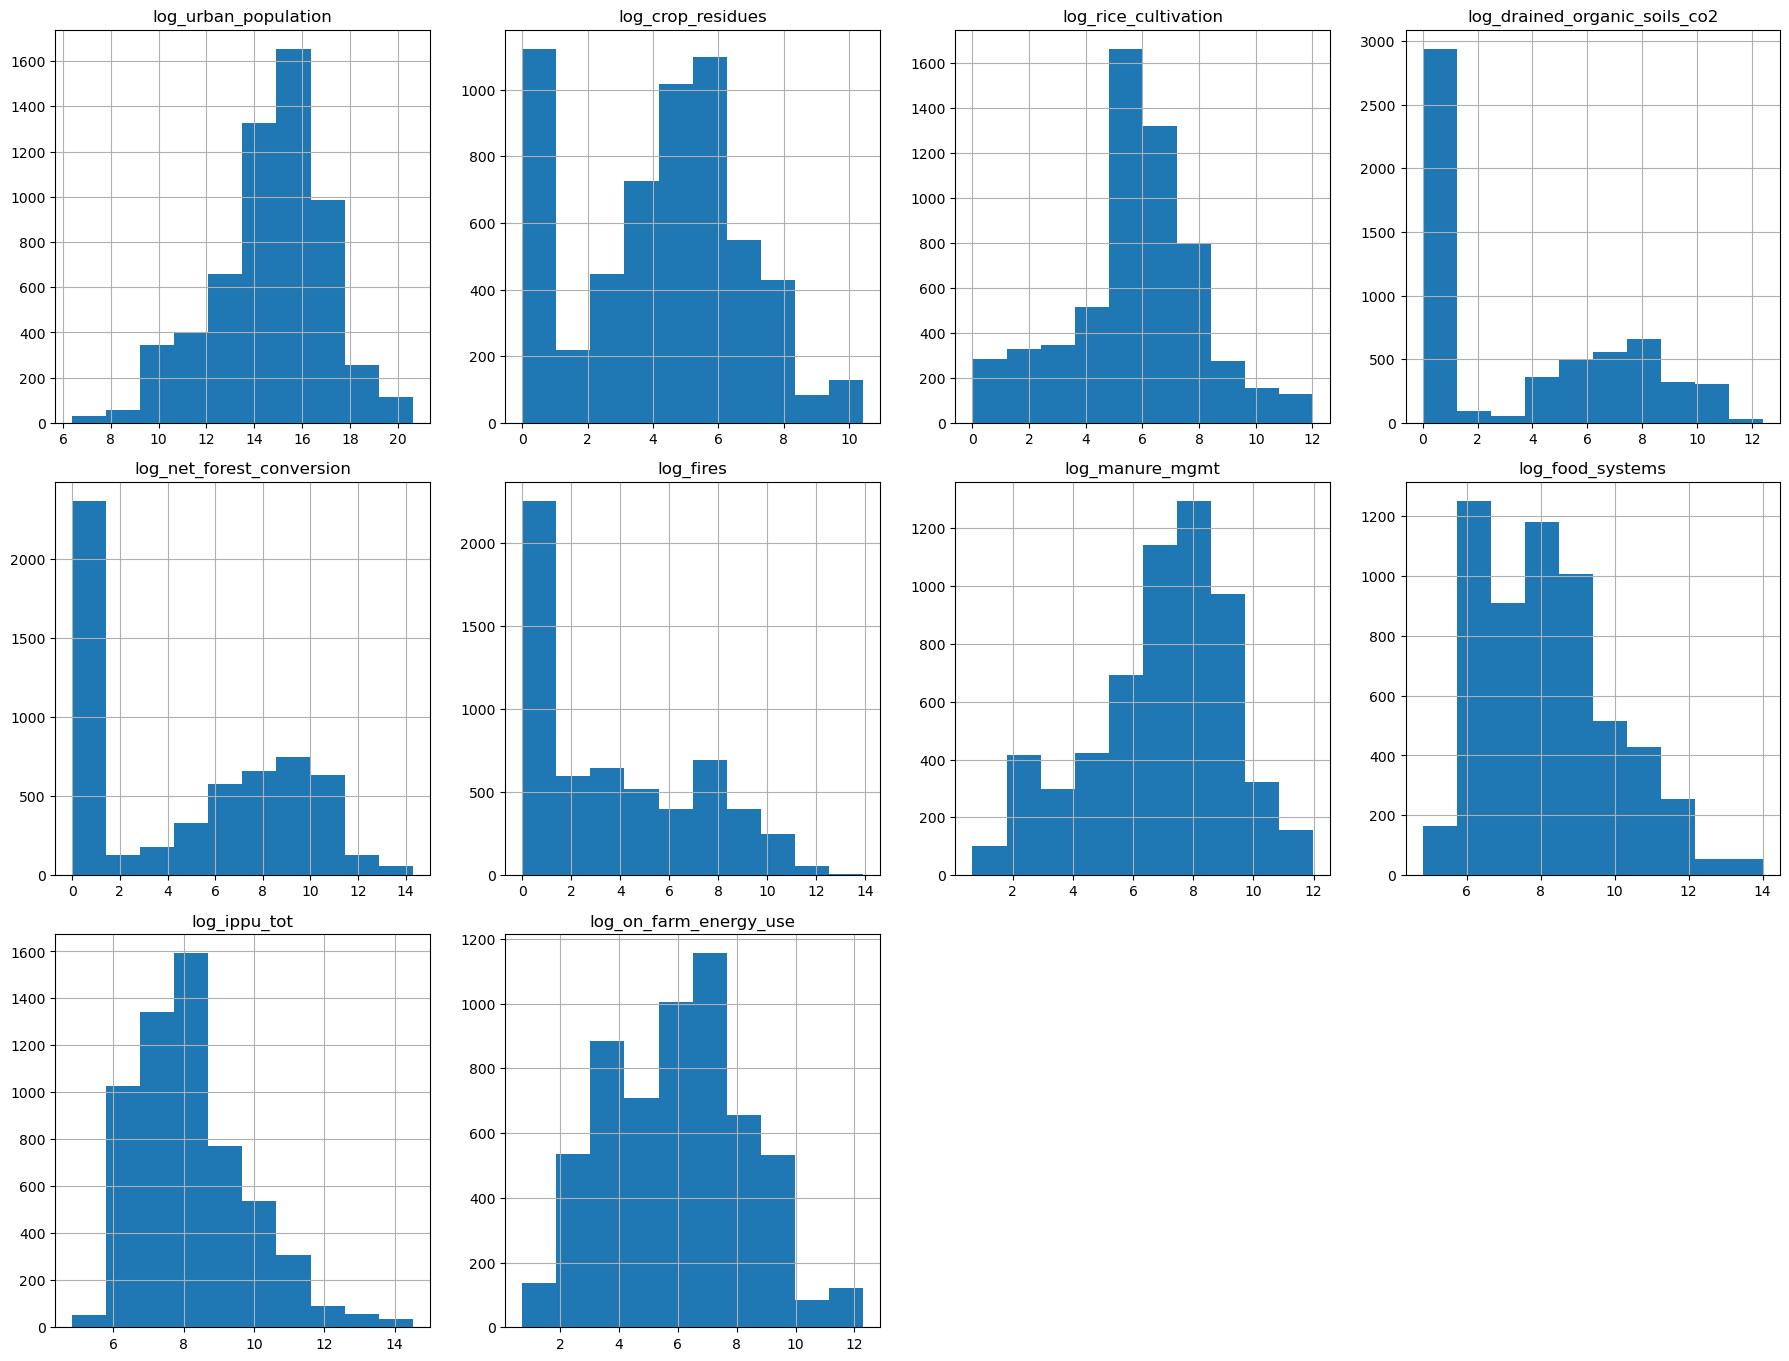

In [56]:
log_vars = [
 'log_urban_population',
 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use']

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,18))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(ag_data, log_vars, 4,4)

### Compute Cumulative Sum for each column

In [57]:
def calc_cum_sum(df, column):
    return (df
            .groupby('area')[column]
            .cumsum())
# ag_data['cumsum_rice_cultivation'] = ag_data.groupby('area')['log_rice_cultivation'].cumsum()

# cols = ['year','area','log_rice_cultivation','cumsum_rice_cultivation']
# ag_data[cols].sort_values(by=['area','year'])

In [58]:
cols = [ 'log_crop_residues',
 'log_rice_cultivation',
 'log_drained_organic_soils_co2',
 'log_net_forest_conversion',
 'log_fires',
 'log_manure_mgmt',
 'log_food_systems',
 'log_ippu_tot',
 'log_on_farm_energy_use', 'forestland', 'total_emission']

In [59]:
for col in cols:
    ag_data['cum_sum_'+str(col)] = calc_cum_sum(ag_data, col)

In [60]:
cols = ['year','area','log_crop_residues','cum_sum_log_crop_residues']
ag_data[cols].sort_values(by=['area','year'])

,year,area,log_crop_residues,cum_sum_log_crop_residues
0,1990,Afghanistan,5.330822,5.330822
202,1991,Afghanistan,5.349472,10.680294
407,1992,Afghanistan,5.285911,15.966205
630,1993,Afghanistan,5.445950,21.412155
855,1994,Afghanistan,5.493265,26.905420
...,...,...,...,...
6056,2016,Zimbabwe,4.275903,127.874171
6283,2017,Zimbabwe,4.697076,132.571247
6510,2018,Zimbabwe,4.709382,137.280629
6737,2019,Zimbabwe,3.838536,141.119164


### Compute rolling totals & Add new columns

 Rolling totals leave too many null values - Use cumulative sum instaed

In [61]:
# def calc_rolling_total(df, column, time_period):
#     return (df
#             .groupby('area')[column]
#             .transform(lambda df: df.rolling(time_period).sum()))

In [62]:
# cols = [ 'log_crop_residues',
#  'log_rice_cultivation',
#  'log_drained_organic_soils_co2',
#  'log_net_forest_conversion',
#  'log_fires',
#  'log_manure_mgmt',
#  'log_food_systems',
#  'log_ippu_tot',
#  'log_on_farm_energy_use', 'forestland', 'total_emission']



In [63]:
# for col in cols:
#     ag_data['5yr_'+str(col)] = calc_rolling_total(ag_data, col, 5)

In [64]:
# for col in cols:
#     ag_data['10yr_'+str(col)] = calc_rolling_total(ag_data, col, 10)

In [65]:
# for col in cols:
#     ag_data['20yr_'+str(col)] = calc_rolling_total(ag_data, col, 20)

In [66]:
# ag_data.tail()

In [67]:
# ag_data = ag_data.fillna(0)

In [68]:
# ag_data.isnull().sum()

In [69]:
ag_data.columns

Index(['area', 'year', 'crop_residues', 'rice_cultivation',
       'drained_organic_soils_co2', 'forestland', 'net_forest_conversion',
       'urban_population', 'total_emission', 'average_temperature_°c', 'fires',
       'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'mei',
       'region', 'sub-region', 'log_urban_population', 'log_crop_residues',
       'log_rice_cultivation', 'log_drained_organic_soils_co2',
       'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt',
       'log_food_systems', 'log_ippu_tot', 'log_on_farm_energy_use',
       'cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation',
       'cum_sum_log_drained_organic_soils_co2',
       'cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
       'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems',
       'cum_sum_log_ippu_tot', 'cum_sum_log_on_farm_energy_use',
       'cum_sum_forestland', 'cum_sum_total_emission'],
      dtype='object')

### Reorder Columns

In [70]:
reordered_cols = ['area', 'region', 'sub-region', 'year', 'urban_population', 'mei', 'crop_residues', 
                  'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion',
                  'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
                  'log_urban_population', 'log_crop_residues','log_rice_cultivation', 'log_drained_organic_soils_co2',
                  'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot', 
                  'log_on_farm_energy_use', 'cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation',
                  'cum_sum_log_drained_organic_soils_co2','cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
                  'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems','cum_sum_log_ippu_tot', 
                  'cum_sum_log_on_farm_energy_use','cum_sum_forestland', 'cum_sum_total_emission', 
                  'average_temperature_°c']

ag_data = ag_data[reordered_cols]

ag_data.head()

,area,region,sub-region,year,urban_population,mei,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,...,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission,average_temperature_°c
0,Afghanistan,Asia,Southern Asia,1990,2593947.0,0.2,205.607700,686.000000,0.0000,-2388.8030,...,0.000000,0.000000,2.758705,7.682875,7.142416,5.458659,9.108153,-2388.8030,2198.963539,0.536167
1,Albania,Europe,Southern Europe,1990,1195379.0,0.2,59.239100,23.520000,110.5705,72.8581,...,4.714657,0.000000,2.608701,6.961908,6.478738,7.026992,5.905609,72.8581,3475.291240,0.735750
2,Algeria,Africa,Northern Africa,1990,13496502.0,0.2,164.277600,4.312000,0.0000,-111.1403,...,0.000000,6.530780,4.981513,7.922930,9.491886,8.573437,4.960281,-111.1403,22326.596965,1.005583
4,Andorra,Europe,Southern Europe,1990,51627.0,0.2,463.085667,926.342278,0.0000,0.0000,...,0.000000,0.000000,0.000000,8.619916,6.347409,7.445527,4.326834,0.0000,5576.553292,1.278500
5,Angola,Africa,Sub-Saharan Africa,1990,4520997.0,0.2,32.352300,24.727400,346.4974,0.0000,...,5.850757,9.195046,10.923926,7.459679,7.495826,6.334018,3.476039,0.0000,69866.840429,0.676667


## Split train, validation, and test data

~ 80% (1990-2014)
</br>~ 10% (2015-2017)
</br>~ 10% (2018-2020)

In [71]:
train = ag_data[ag_data['year'] <= 2014]
val = ag_data[(ag_data['year'] >= 2015) & (ag_data['year'] <= 2017)]
test = ag_data[ag_data['year'] >= 2018]

### Standaradize input variables in training datset

In [72]:
#Create a list of all features that need to be standardized
features = [      'urban_population','crop_residues', 'rice_cultivation', 'drained_organic_soils_co2', 'forestland', 'net_forest_conversion',
                  'fires', 'manure_mgmt', 'food_systems', 'ippu_tot', 'on_farm_energy_use', 'total_emission',
                  'log_urban_population', 'log_crop_residues','log_rice_cultivation', 'log_drained_organic_soils_co2',
                  'log_net_forest_conversion', 'log_fires', 'log_manure_mgmt', 'log_food_systems', 'log_ippu_tot', 
                  'log_on_farm_energy_use', 'cum_sum_log_crop_residues', 'cum_sum_log_rice_cultivation',
                  'cum_sum_log_drained_organic_soils_co2','cum_sum_log_net_forest_conversion', 'cum_sum_log_fires',
                  'cum_sum_log_manure_mgmt', 'cum_sum_log_food_systems','cum_sum_log_ippu_tot', 
                  'cum_sum_log_on_farm_energy_use','cum_sum_forestland', 'cum_sum_total_emission'
           ]

In [73]:
#Standardize train dataset

scaler = StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])

In [74]:
#Standardize val and test datasets using train mean and st deviation

val[features] = scaler.transform(val[features])
test[features] = scaler.transform(test[features])

In [75]:
#Verify standardization was performed correctly
train[features].describe()
val[features].describe()
test[features].describe()

,urban_population,crop_residues,rice_cultivation,drained_organic_soils_co2,forestland,net_forest_conversion,fires,manure_mgmt,food_systems,ippu_tot,...,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,cum_sum_total_emission
count,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,...,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000,570.000000
mean,0.125584,0.076226,0.005211,0.015907,0.028248,-0.046638,-0.020256,0.039763,0.097785,0.159084,...,1.814686,0.956242,1.101980,1.039372,1.949069,2.182682,2.230004,1.856854,-0.309649,0.454547
std,1.530780,1.271243,0.998321,1.142584,1.029136,0.592365,0.803191,1.032216,1.516234,1.890316,...,1.297191,1.849628,1.702856,1.785420,1.159617,0.838634,0.754792,1.255394,2.097661,2.324237
min,-0.288779,-0.267498,-0.236026,-0.241248,-7.424672,-0.182134,-0.162300,-0.350583,-0.259605,-0.201886,...,-1.362283,-0.726651,-0.863273,-0.851537,-1.112231,0.444571,0.695325,-0.587704,-16.317151,-1.771512
25%,-0.271117,-0.264534,-0.228670,-0.241248,0.212754,-0.182134,-0.162299,-0.334569,-0.247272,-0.190455,...,1.193460,-0.726651,-0.863273,-0.643238,1.284042,1.480134,1.667277,0.811720,0.122571,-0.235211
50%,-0.219965,-0.229508,-0.214639,-0.241142,0.243957,-0.180407,-0.161816,-0.261251,-0.213699,-0.169665,...,1.819506,-0.312476,0.965248,0.632157,2.153291,2.108943,2.102000,1.852575,0.220257,-0.143797
75%,-0.044279,-0.135389,-0.170063,-0.175369,0.244421,-0.132304,-0.138201,-0.046283,-0.124963,-0.088366,...,2.561381,2.647429,2.713622,2.684053,2.763016,2.654348,2.623017,2.725755,0.230739,0.188678
max,13.748158,9.530572,7.570413,14.232586,1.144573,5.562733,15.408896,7.077512,14.251453,18.654003,...,5.517792,5.387611,5.185387,5.650272,4.657531,4.977130,5.114477,5.435557,0.970896,19.694161


In [76]:
#Confirm size of train, val, and test datasets

print(train.shape)
print(val.shape)
print(test.shape)

(4681, 39)
(570, 39)
(570, 39)


### Export Train, Val, Test Data to CSV

In [77]:
train.to_csv('train_data.csv',index=False)
val.to_csv('val_data.csv',index=False)
test.to_csv('test_data.csv',index=False)